<a href="https://colab.research.google.com/github/PoulYak/ALL-RUSSIAN-CONF/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%5Bhw%5Dsemantic_segmentation_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>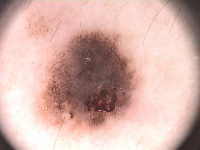</td><td>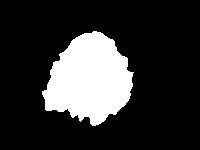</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-12-21 17:33:29--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-12-21 17:33:29--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc63b663043eb78937adf900aa3c.dl.dropboxusercontent.com/cd/0/inline/BFgKmQPetK5MYk3O_nik5vEyUxySh_-8Db4MJkvuuZH9Y-qOCBz3BieTzhsh9i2FRjqLw1USuyE0pmvLTz_OiJ7V7vRV0fdEWxyD8DxEyk8Pcg/file# [following]
--2020-12-21 17:33:30--  https://uc63b663043eb78937adf900aa3c.dl.dropboxusercontent.com/cd/0/inline/BFgKmQPetK5MYk3O_nik5vEyUxySh_-8Db4MJkvuuZH9Y-qOCBz3BieTzhsh9i2FRjqLw1USuyE0pmvLTz_OiJ7V7vRV0fdEWxyD8DxEyk8Pcg/file
Resolving 

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

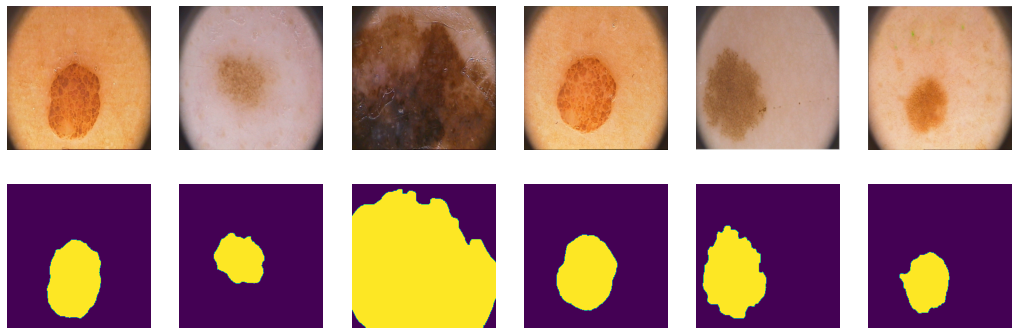

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

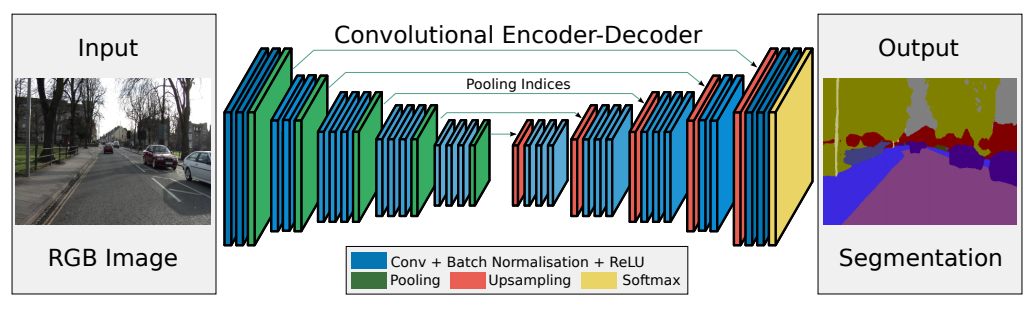

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
def easy_layer(in_ch, out_ch, dec = False, last = False):
    if not dec:
        if not last:
            return nn.Sequential(
                nn.Conv2d(in_channels = in_ch, out_channels=out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU()
            )
        return nn.Sequential(
                nn.Conv2d(in_channels = in_ch, out_channels=out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
            )
    else:
        if not last:
            return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
            
        )
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch)
            
        )


    



In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        

        self.layer0 = nn.Sequential(
            easy_layer(3,64)

        )

        self.layer1 = nn.Sequential(
            easy_layer(64, 128)
        )

        self.layer2 = nn.Sequential(
            easy_layer(128, 256),
            easy_layer(256, 256)  

        )

        self.layer3 = nn.Sequential(
            easy_layer(256, 512),
            easy_layer(512, 512)   

        )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(

          nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False),
          nn.BatchNorm2d(512),
          nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        

        self.de_layer0 = nn.Sequential(
            easy_layer(512, 512, dec = True),
            easy_layer(512, 256, dec = True)

        )
        self.de_layer1 = nn.Sequential(
            easy_layer(256, 256, dec = True),
            easy_layer(256, 128, dec = True)

        )
        self.de_layer2  = nn.Sequential(
            easy_layer(128, 64, dec = True)
        )
        self.de_layer3  = nn.Sequential(
            easy_layer(64, 1, dec = True, last = True)
        )

        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, stride=2)


    def forward(self, x):
        # encoder
        x = self.layer0(x)
        x, ids0 = self.pool(x)
        x = self.layer1(x)
        x, ids1 = self.pool(x)
        x = self.layer2(x)
        x, ids2 = self.pool(x)
        x = self.layer3(x)
        x, ids3 = self.pool(x)

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.unpool(x, ids3)
        x = self.de_layer0(x)
        x = self.unpool(x, ids2)
        x = self.de_layer1(x) 
        x = self.unpool(x, ids1)
        x = self.de_layer2(x)
        x = self.unpool(x, ids0)
        x = self.de_layer3(x)
        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def plot_trainig(train_losses, valid_losses, loss=True,subtitle=''):
    st = 'loss' if loss == True else 'score'
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_'+st)
    plt.plot(valid_losses, label='valid_'+st)
    plt.title(subtitle)
    plt.legend()

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    res =  y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))
    return res.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, lr_sched=False ):
    train_losses, val_losses, score_train, score_val = [], [], [], []
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        train_losses.append(avg_loss)
        toc = time()
        
        # show intermediate results
        model.eval()  # testing mode

        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
        if type(lr_sched) is not bool:
            lr_sched.step(avg_loss)

        loss_sum = 0
        counter = 0
        avg_val_loss = 0
        with torch.no_grad():
            for X_batch, Y_batch in data_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                Y_preds = model(X_batch)
                loss = loss_fn(Y_batch, Y_preds)
                avg_val_loss += loss / len(data_val)
        score_val.append(score_model(model, iou_pytorch, data_val))
        score_train.append(score_model(model, iou_pytorch, data_tr))
        val_losses.append(avg_val_loss)
        print('test_loss: %f' % avg_loss)
        print('val_loss: %f' % avg_val_loss)
        Y_hat = nn.Sigmoid()(Y_hat)
                
        # Visualize tools
        clear_output(wait=True)
        for k in range(10):
            plt.subplot(3, 10, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            

            plt.subplot(3, 10, k+11)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 10, k+21)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Target')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f;   %f' % (epoch+1, epochs, avg_loss, avg_val_loss))
        plt.show()
    return train_losses, val_losses, score_train, score_val

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        scores += metric(Y_pred > 0.5, Y_label.to(device)).mean().item()
    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


*Все графики и скоры в конце*

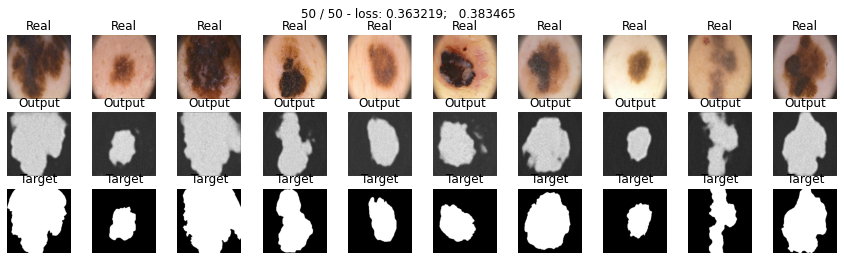

In [ ]:
model = SegNet().to(device)
max_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)
tr_losses_bce, val_losses_bce, tr_score_bce, val_score_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, scheduler)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred, smooth=1):
    y_pred = F.sigmoid(y_pred)       
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    intersection = (y_pred * y_real).sum()                            
    dice = (2.*intersection + smooth)/(y_pred.sum() + y_real.sum() + smooth)  
    return 1 - dice

Проводим тестирование:

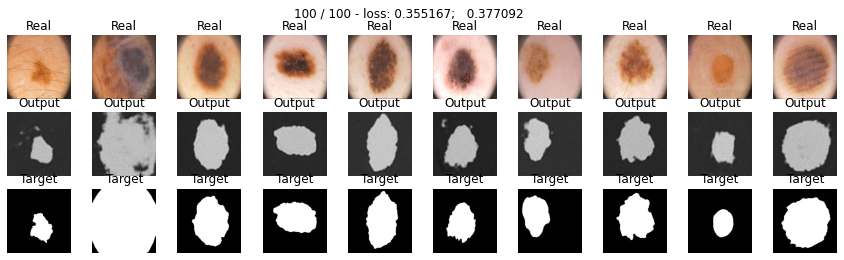

In [ ]:
model_dice = SegNet().to(device)
optimaizer = optim.Adam(model_dice.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimaizer, 2, gamma=0.5)
max_epochs =100
tr_losses_dice, val_losses_dice, tr_score_dice, val_score_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, scheduler)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  torch.clamp(y_pred, eps, 1.0)     

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    BCE = bce_loss(y_real, y_pred)
    BCE_EXP = torch.exp(-BCE)
    focal_loss = 1 * (1-BCE_EXP)**gamma * BCE
                   
    return focal_loss


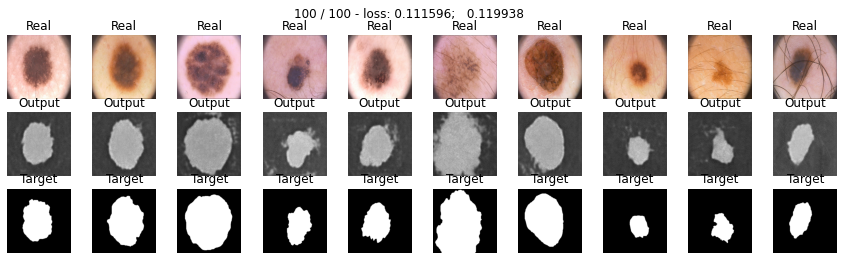

In [ ]:
model_focal = SegNet().to(device)
max_epochs = 100
optimaizer = optim.Adam(model_focal.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimaizer, 2, gamma=0.5)
tr_losses_focal, val_losses_focal, tr_score_focal, val_score_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, scheduler)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
ALPHA = 0.8
BETA = 0.8
def tversky_loss( y_real,y_pred, smooth=1, alpha=ALPHA, beta=BETA):
    y_pred = F.sigmoid(y_pred)       

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    TP = (y_pred * y_real).sum()    
    FP = ((1-y_real) * y_pred).sum()
    FN = (y_real * (1-y_pred)).sum()
    
    Tversky = (TP) / (TP + FP + FN)  
    
    return 1 - Tversky

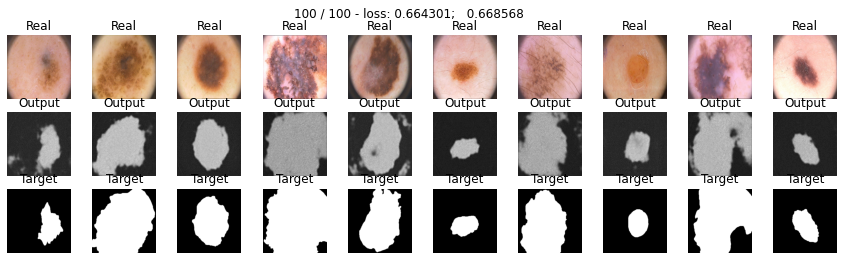

In [ ]:
model_tversky = SegNet().to(device)
optimaizer = optim.Adam(model_tversky.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimaizer, 2, gamma=0.5)
max_epochs = 100
tr_losses_tversky, val_losses_tversky, tr_score_tversky, val_score_tversky = train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val, scheduler)

Посмотрел, как реализован bce в tensorflow, т.к. при обучении юнета у меня появлялись наны в лоссах, но переделывать для сегнета, было слишком поздно, т.к. там и так всё обучил, скорее всего после сдачи доработаю, но сейчас уже не успею. Поэтому решил использовать только на Unet

In [ ]:
def bce_loss_for_unet(y_real, y_pred):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    m = torch.zeros(y_pred.shape).to(device)
    res =  torch.max(y_pred, m) - y_pred*y_real+ torch.log(1 + torch.exp(-y_pred))
    return res.mean()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

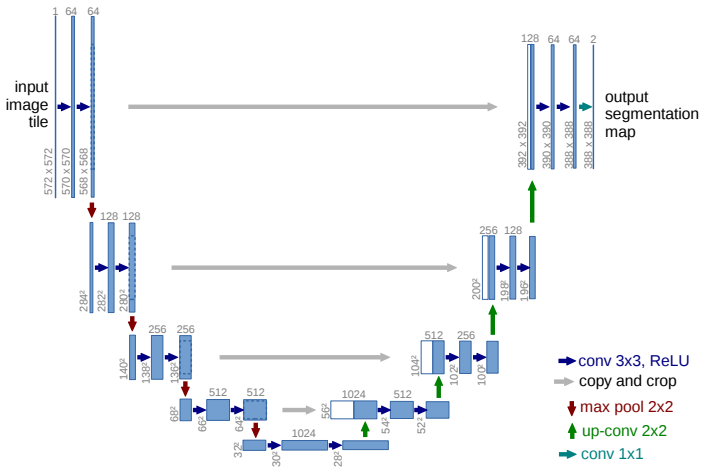

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.upsample = nn.Upsample(scale_factor=2)
        self.pool0 = nn.MaxPool2d(3, 2, 1)  # 256 -> 128, 128 -> 64, 64 -> 32, 32 -> 16

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential( nn.Conv2d(in_channels = 3, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.enc_conv1 = nn.Sequential( nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.enc_conv2 = nn.Sequential( nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.enc_conv3 = nn.Sequential( nn.Conv2d(in_channels = 256, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )


        # bottleneck
        self.bottleneck_conv = nn.Sequential( nn.Conv2d(in_channels = 512, out_channels=1024, kernel_size=3, padding=1), nn.ReLU(inplace=True),nn.Conv2d(in_channels = 1024, out_channels=1024, kernel_size=3, padding=1), nn.ReLU(inplace=True)  )

        # decoder (upsampling)
                
        self.up_conv0 = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(in_channels = 1024, out_channels=512, kernel_size=3, padding=1))
        self.dec_conv0 = nn.Sequential( nn.Conv2d(in_channels = 1024, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.up_conv1 = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, padding=1))
        self.dec_conv1 = nn.Sequential( nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.up_conv2 = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, padding=1))
        self.dec_conv2 = nn.Sequential( nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.up_conv3 = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, padding=1))
        self.dec_conv3 = nn.Sequential( nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace=True),nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(in_channels = 64, out_channels=1, kernel_size=1)  )

    def forward(self, x):


        # encoder
        x0 = self.enc_conv0(x)
        x = self.pool0(x0)
        x1 = self.enc_conv1(x)
        x = self.pool0(x1)
        x2 = self.enc_conv2(x)
        x = self.pool0(x2)
        x3 = self.enc_conv3(x)
        x = self.pool0(x3)

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.up_conv0(x)
        x = torch.cat([x, x3], dim =1)
        x = self.dec_conv0(x)
        x = self.up_conv1(x)
        x = torch.cat([x, x2], dim =1)
        x = self.dec_conv1(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x1], dim =1)
        x = self.dec_conv2(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x0], dim =1)
        x = self.dec_conv3(x)
        return x

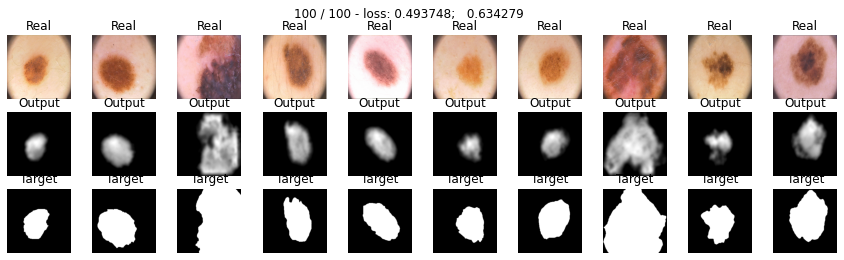

In [ ]:
unet_model = UNet().to(device)
optimaizer = optim.Adam(unet_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimaizer, 2, gamma=0.5)
tr_losses_unet, val_losses_unet, tr_score_unet, val_score_unet = train(unet_model, optimaizer, bce_loss_for_unet, 100, data_tr, data_val, False)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        # self.upsample = nn.Upsample(scale_factor=2)
        self.pool0 = nn.Conv2d(64, 64, 2, stride=2)  # 256 -> 128, 128 -> 64, 64 -> 32, 32 -> 16
        self.pool1 = nn.Conv2d(128, 128, 2, stride=2)
        self.pool2 = nn.Conv2d(256, 256, 2, stride=2)
        self.pool3 = nn.Conv2d(512, 512, 2, stride=2)
        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential( nn.Conv2d(in_channels = 3, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.enc_conv1 = nn.Sequential( nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.enc_conv2 = nn.Sequential( nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.enc_conv3 = nn.Sequential( nn.Conv2d(in_channels = 256, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )


        # bottleneck
        self.bottleneck_conv = nn.Sequential( nn.Conv2d(in_channels = 512, out_channels=1024, kernel_size=3, padding=1), nn.ReLU(inplace=True),nn.Conv2d(in_channels = 1024, out_channels=1024, kernel_size=3, padding=1), nn.ReLU(inplace=True)  )

        # decoder (upsampling)
                
        self.up_conv0 = nn.Sequential(nn.ConvTranspose2d(1024, 1024, 2, stride=2), nn.Conv2d(in_channels = 1024, out_channels=512, kernel_size=3, padding=1))
        self.dec_conv0 = nn.Sequential( nn.Conv2d(in_channels = 1024, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.up_conv1 = nn.Sequential(nn.ConvTranspose2d(512, 512, 2, stride=2), nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, padding=1))
        self.dec_conv1 = nn.Sequential( nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.up_conv2 = nn.Sequential(nn.ConvTranspose2d(256, 256, 2, stride=2), nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, padding=1))
        self.dec_conv2 = nn.Sequential( nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace =True),nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace =True)  )
        self.up_conv3 = nn.Sequential(nn.ConvTranspose2d(128, 128, 2, stride=2), nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, padding=1))
        self.dec_conv3 = nn.Sequential( nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace=True),nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(in_channels = 64, out_channels=1, kernel_size=1)  )

    def forward(self, x):


        # encoder
        x0 = self.enc_conv0(x)
        x = self.pool0(x0)
        # print(x.shape)
        x1 = self.enc_conv1(x)
        x = self.pool1(x1)
        # print(x.shape)
        x2 = self.enc_conv2(x)
        x = self.pool2(x2)
        # print(x.shape)
        x3 = self.enc_conv3(x)
        x = self.pool3(x3)
        # print(x.shape)
        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.up_conv0(x)
        x = torch.cat([x, x3], dim =1)
        x = self.dec_conv0(x)
        x = self.up_conv1(x)
        x = torch.cat([x, x2], dim =1)
        x = self.dec_conv1(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x1], dim =1)
        x = self.dec_conv2(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x0], dim =1)
        x = self.dec_conv3(x)
        return x

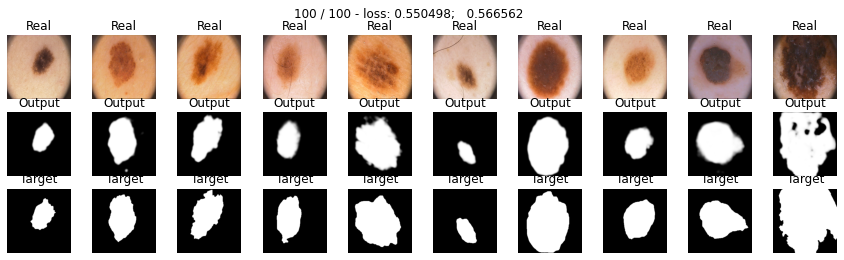

In [ ]:
unet2_model = UNet2().to(device)
optimaizer = optim.Adam(unet2_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimaizer, 2, gamma=0.5)
tr_losses_unet2, val_losses_unet2, tr_score_unet2, val_score_unet2 = train(unet2_model, optimaizer, bce_loss_for_unet, 100, data_tr, data_val, scheduler)

Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# SegNet

## BCE loss


### График изменения лосса

Конечный скор 0.8260000467300415


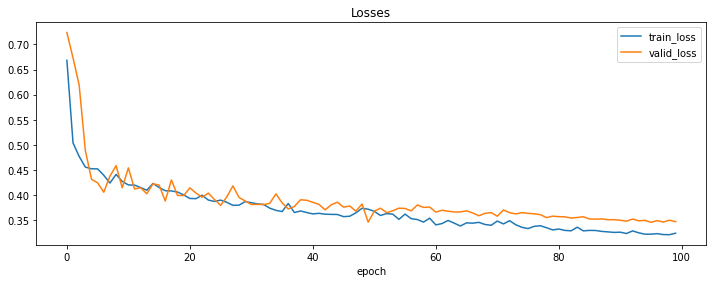

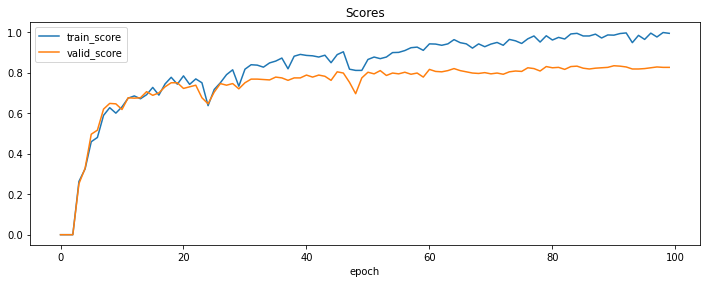

In [ ]:
plot_trainig(tr_losses_bce, val_losses_bce, True, 'Losses')
plot_trainig(tr_score_bce, val_score_bce, False, 'Scores')
print("Конечный скор {}".format(score_model(model, iou_pytorch, data_val)))

График лосса хороший, но модель переобучается

## Dice loss

### График изменения лосса


Конечный скор 0.7800000309944153


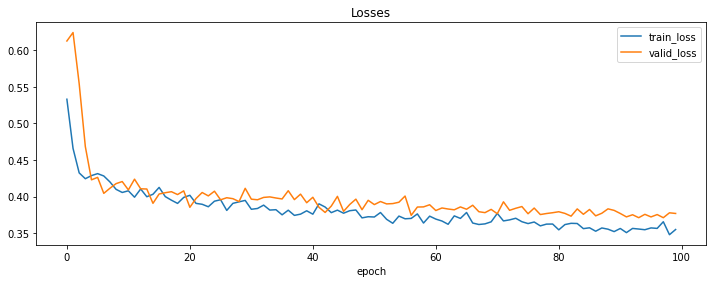

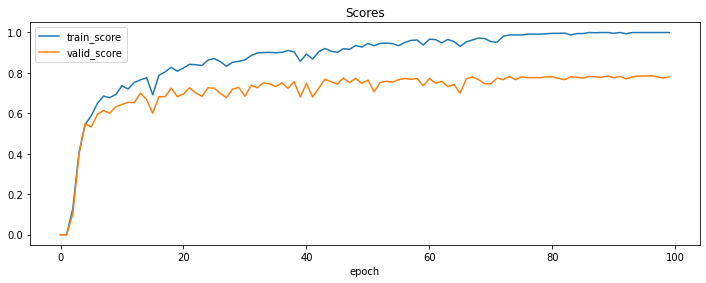

In [ ]:
plot_trainig(tr_losses_dice, val_losses_dice, True, 'Losses')
plot_trainig(tr_score_dice, val_score_dice, False, 'Scores')
print("Конечный скор {}".format(score_model(model_dice, iou_pytorch, data_val)))

График лосса неплохой, но на скоре так же как и с прошлым лоссом присутсятвует переобучение




## Focal loss

### Графики изменения лосса и скора

Конечный скор 0.7800000190734864


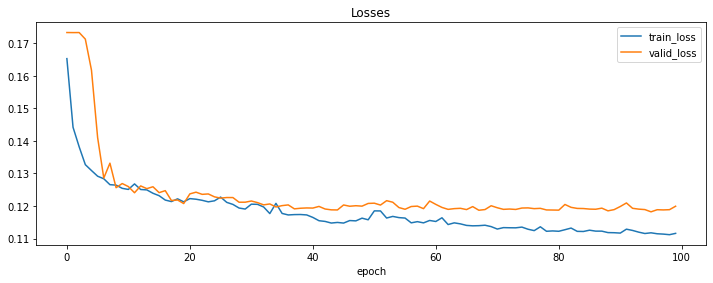

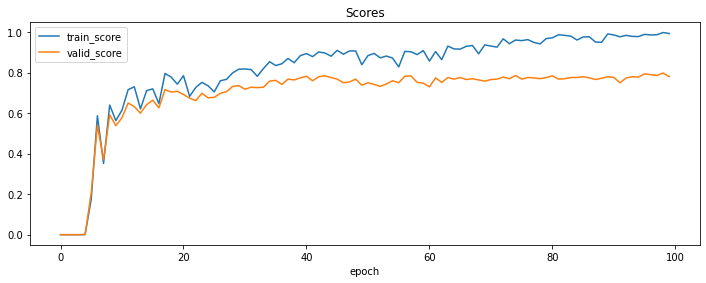

In [ ]:
plot_trainig(tr_losses_focal, val_losses_focal, True, 'Losses')
plot_trainig(tr_score_focal, val_score_focal, False, 'Scores')
print("Конечный скор {}".format(score_model(model_focal, iou_pytorch, data_val)))


График лосса хороший, в скоре переобучение

## Лосс из твери Tversky)

### Графики изменения лосса и скора



Конечный скор 0.7760000467300415


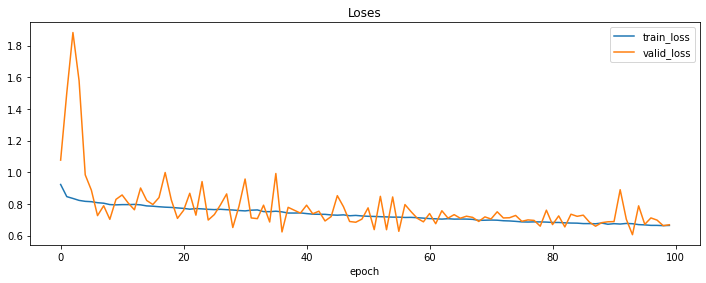

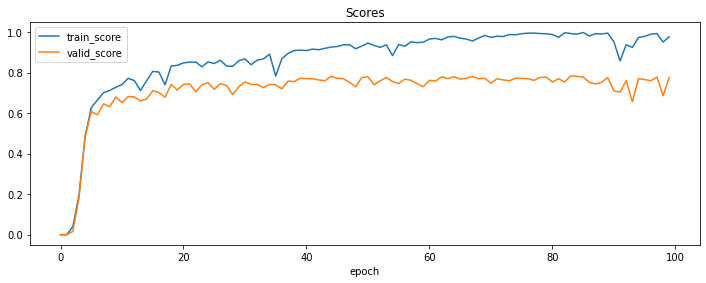

In [ ]:
plot_trainig(tr_losses_tversky, val_losses_tversky, True,'Loses')
plot_trainig(tr_score_tversky, val_score_tversky, False,'Scores')
print("Конечный скор {}".format(score_model(model_tversky, iou_pytorch, data_val)))

Резкие скачки на лоссе в валидационной выборке, на скоре так же переобучается

# Unet

### Графики изменения лосса и скора

Конечный скор 0.7560000419616699


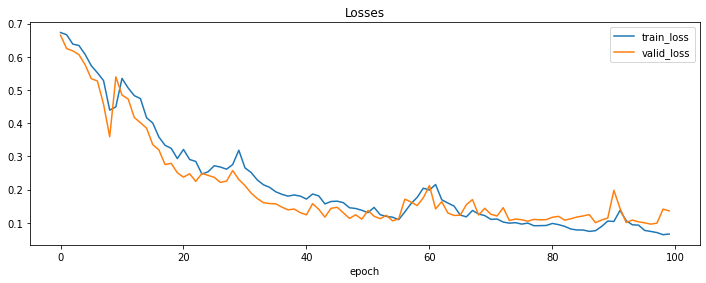

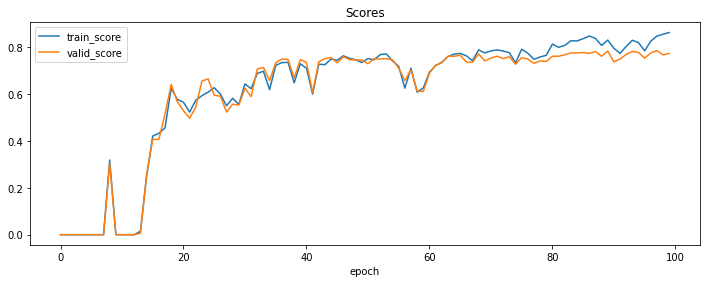

In [ ]:
plot_trainig(tr_losses_unet, val_losses_unet, True, 'Losses')
plot_trainig(tr_score_unet, val_score_unet, False, 'Scores')
print("Конечный скор {}".format(score_model(unet_model, iou_pytorch, data_val)))

График лосса странный, но скор удовлетворяет, присутствует совсем маленькое переобучение

# Unet2

Конечный скор 0.7420000195503235


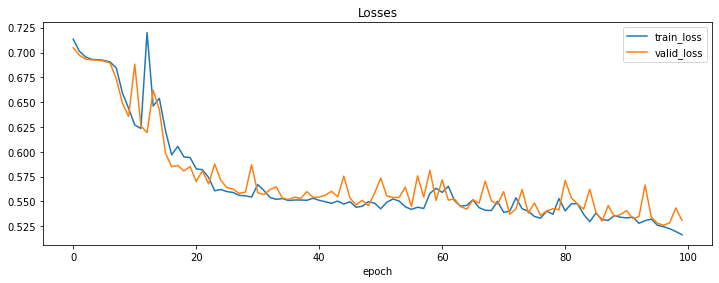

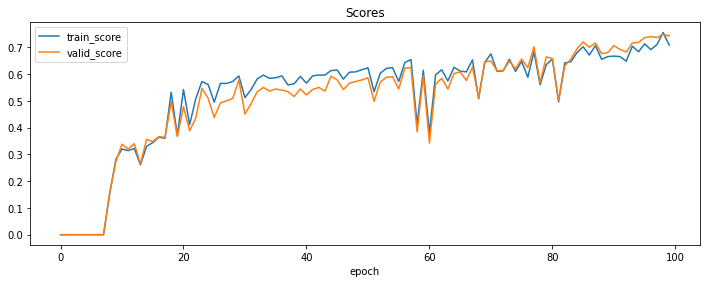

In [ ]:
plot_trainig(tr_losses_unet2, val_losses_unet2, True, 'Losses')
plot_trainig(tr_score_unet2, val_score_unet2, False, 'Scores')
print("Конечный скор {}".format(score_model(unet2_model, iou_pytorch, data_val)))

Хоть и присутствуют резкие скачки лосса в валидации, модель наиболее стабильная и не переобучается

---
# Вывод

В моём случае наилучший скор показал bce_loss на модели segnet, но в целом все модели я смог обучить примерно с одинаковым скором, но segnet обучается в моем случае быстрее
Но последняя модель абсолютно не переобучается, что кажется для меня несомненным плюсом, и поэтому её можно назвать лучшей модель из представленных

---

*Благодарю того, кто проверяет мой ноутбук, что не закрыли его в самом начале, не надеюсь что у меня всё правильно, но я уверен что это был полезное задание. В целом, чем сложнее домашнее задание, тем полезнее, хоть это ужасно сложно, по крайней мере для меня)*